<a href="https://colab.research.google.com/github/bonnieliu2002/CSM146/blob/main/ps1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sys

In [ ]:
# To add your own Drive Run this cell.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Please append your own directory after ‘/content/drive/My Drive/'
# where you have nutil.py and adult_subsample.csv
### ========== TODO : START ========== ###
sys.path += ['/content/drive/My Drive/CS M146'] 
### ========== TODO : END ========== ###


In [ ]:
from nutil import *

In [ ]:
# Use only the provided packages!
import math
import csv

from collections import Counter

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit

In [ ]:
######################################################################
# Immutatble classes
######################################################################

class Classifier(object) :
    """
    Classifier interface.
    """

    def fit(self, X, y):
        raise NotImplementedError()

    def predict(self, X):
        raise NotImplementedError()


class MajorityVoteClassifier(Classifier) :

    def __init__(self) :
        """
        A classifier that always predicts the majority class.

        Attributes
        --------------------
            prediction_ -- majority class
        """
        self.prediction_ = None

    def fit(self, X, y) :
        """
        Build a majority vote classifier from the training set (X, y).

        Parameters
        --------------------
            X    -- numpy array of shape (n,d), samples
            y    -- numpy array of shape (n,), target classes

        Returns
        --------------------
            self -- an instance of self
        """
        majority_val = Counter(y).most_common(1)[0][0]
        self.prediction_ = majority_val
        return self

    def predict(self, X) :
        """
        Predict class values.

        Parameters
        --------------------
            X    -- numpy array of shape (n,d), samples

        Returns
        --------------------
            y    -- numpy array of shape (n,), predicted classes
        """
        if self.prediction_ is None :
            raise Exception("Classifier not initialized. Perform a fit first.")

        n,d = X.shape
        y = [self.prediction_] * n
        return y



In [ ]:
######################################################################
# Mutatble classes
######################################################################

class RandomClassifier(Classifier) :

    def __init__(self) :
        """
        A classifier that predicts according to the distribution of the classes.

        Attributes
        --------------------
            probabilities_ -- class distribution dict (key = class, val = probability of class)
        """
        self.probabilities_ = None

    def fit(self, X, y) :
        """
        Build a random classifier from the training set (X, y).

        Parameters
        --------------------
            X    -- numpy array of shape (n,d), samples
            y    -- numpy array of shape (n,), target classes

        Returns
        --------------------
            self -- an instance of self
        """

        ### ========== TODO : START ========== ###
        # part b: set self.probabilities_ according to the training set
        n,d = X.shape
        self.probabilities_ = {0: 1 - 1.0 * sum(y) / n, 1: 1.0 * sum(y) / n}

        ### ========== TODO : END ========== ###

        return self

    def predict(self, X, seed=1234) :
        """
        Predict class values.

        Parameters
        --------------------
            X    -- numpy array of shape (n,d), samples
            seed -- integer, random seed

        Returns
        --------------------
            y    -- numpy array of shape (n,), predicted classes
        """
        if self.probabilities_ is None :
            raise Exception("Classifier not initialized. Perform a fit first.")
        np.random.seed(seed)

        ### ========== TODO : START ========== ###
        # part b: predict the class for each test example
        # hint: use np.random.choice (be careful of the parameters)
        n,d = X.shape
        y = np.random.choice(2, n, p=list(self.probabilities_.values()))
        
        ### ========== TODO : END ========== ###

        return y


In [ ]:
######################################################################
# Immutatble functions
######################################################################

def plot_histograms(X, y, Xnames, yname) :
    n,d = X.shape  # n = number of examples, d =  number of features
    fig = plt.figure(figsize=(20,15))
    ncol = 3
    nrow = d // ncol + 1
    for i in range(d) :
        fig.add_subplot (nrow,ncol,i+1)
        data, bins, align, labels = plot_histogram(X[:,i], y, Xname=Xnames[i], yname=yname, show = False)
        n, bins, patches = plt.hist(data, bins=bins, align=align, alpha=0.5, label=labels)
        plt.xlabel(Xnames[i])
        plt.ylabel('Frequency')
        plt.legend() #plt.legend(loc='upper left')

    plt.savefig ('histograms.pdf')


def plot_histogram(X, y, Xname, yname, show = True) :
    """
    Plots histogram of values in X grouped by y.

    Parameters
    --------------------
        X     -- numpy array of shape (n,d), feature values
        y     -- numpy array of shape (n,), target classes
        Xname -- string, name of feature
        yname -- string, name of target
    """

    # set up data for plotting
    targets = sorted(set(y))
    data = []; labels = []
    for target in targets :
        features = [X[i] for i in range(len(y)) if y[i] == target]
        data.append(features)
        labels.append('%s = %s' % (yname, target))

    # set up histogram bins
    features = set(X)
    nfeatures = len(features)
    test_range = list(range(int(math.floor(min(features))), int(math.ceil(max(features)))+1))
    if nfeatures < 10 and sorted(features) == test_range:
        bins = test_range + [test_range[-1] + 1] # add last bin
        align = 'left'
    else :
        bins = 10
        align = 'mid'

    # plot
    if show == True:
        plt.figure()
        n, bins, patches = plt.hist(data, bins=bins, align=align, alpha=0.5, label=labels)
        plt.xlabel(Xname)
        plt.ylabel('Frequency')
        plt.legend() #plt.legend(loc='upper left')
        plt.show()

    return data, bins, align, labels


In [ ]:
######################################################################
# Mutatble functions
######################################################################

def error(clf, X, y, ntrials=100, test_size=0.2) :
    """
    Computes the classifier error over a random split of the data,
    averaged over ntrials runs.

    Parameters
    --------------------
        clf         -- classifier
        X           -- numpy array of shape (n,d), features values
        y           -- numpy array of shape (n,), target classes
        ntrials     -- integer, number of trials

    Returns
    --------------------
        train_error -- float, training error
        test_error  -- float, test error
        f1_score    -- float, test "micro" averaged f1 score
    """

    ### ========== TODO : START ========== ###
    # compute cross-validation error using StratifiedShuffleSplit over ntrials
    # hint: use train_test_split (be careful of the parameters)
    sss = StratifiedShuffleSplit(test_size=test_size, random_state=0)
    # total_train_errors = []
    # total_test_errors = []
    # total_f1_scores = []
    # for i in range(ntrials):
    train_errors = []
    test_errors = []
    f1_scores = []
    for train_index, test_index in sss.split(X, y):
      X_train, X_test = X[train_index], X[test_index]
      y_train, y_test = y[train_index], y[test_index]
      clf.fit(X_train, y_train)             # fit training data using the classifier
      y_pred = clf.predict(X_train)
      train_error = 1 - metrics.accuracy_score(y_train, y_pred, normalize=True)
      train_errors.append(train_error)
      y_pred = clf.predict(X_test)   # take the classifier and run it on the testing data
      test_error = 1 - metrics.accuracy_score(y_test, y_pred, normalize=True)
      test_errors.append(test_error)
      f1_score = metrics.f1_score(y_test, y_pred, average='micro')
      f1_scores.append(f1_score)
    train_error = 1.0 * sum(train_errors) / len(train_errors)
    test_error = 1.0 * sum(test_errors) / len(test_errors)
    f1_score = 1.0 * sum(f1_scores) / len(f1_scores)
      # total_train_errors.append(1.0 * sum(train_errors) / len(train_errors))
      # total_test_errors.append(1.0 * sum(test_errors) / len(test_errors))
      # total_f1_scores.append(1.0 * sum(f1_scores) / len(f1_scores))
    # train_error = 1.0 * sum(total_train_errors) / ntrials
    # test_error = 1.0 * sum(total_test_errors) / ntrials
    # f1_score = 1.0 * sum(total_f1_scores) / ntrials
   
    ### ========== TODO : END ========== ###

    return train_error, test_error, f1_score




In [ ]:
######################################################################
# Immutatble functions
######################################################################


def write_predictions(y_pred, filename, yname=None) :
    """Write out predictions to csv file."""
    out = open(filename, 'wb')
    f = csv.writer(out)
    if yname :
        f.writerow([yname])
    f.writerows(list(zip(y_pred)))
    out.close()


Plotting...


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Classifying using Majority Vote...
	-- training error: 0.240
Classifying using Random...
	-- training error: 0.374
Classifying using Decision Tree...
	-- training error: 0.000
Classifying using k-Nearest Neighbors...
	-- training error: 0.152
Investigating various classifiers...
	-- Majority Vote Classifier
		-- training error: 0.240
		-- test error: 0.240
		-- f1 score: 0.760
	-- Random Classifier
		-- training error: 0.378
		-- test error: 0.381
		-- f1 score: 0.619
	-- Decision Tree Classifier
		-- training error: 0.000
		-- test error: 0.202
		-- f1 score: 0.797
	-- 5-Neighbors Classifier
		-- training error: 0.135
		-- test error: 0.206
		-- f1 score: 0.793
Finding the best k...


<Figure size 432x288 with 0 Axes>

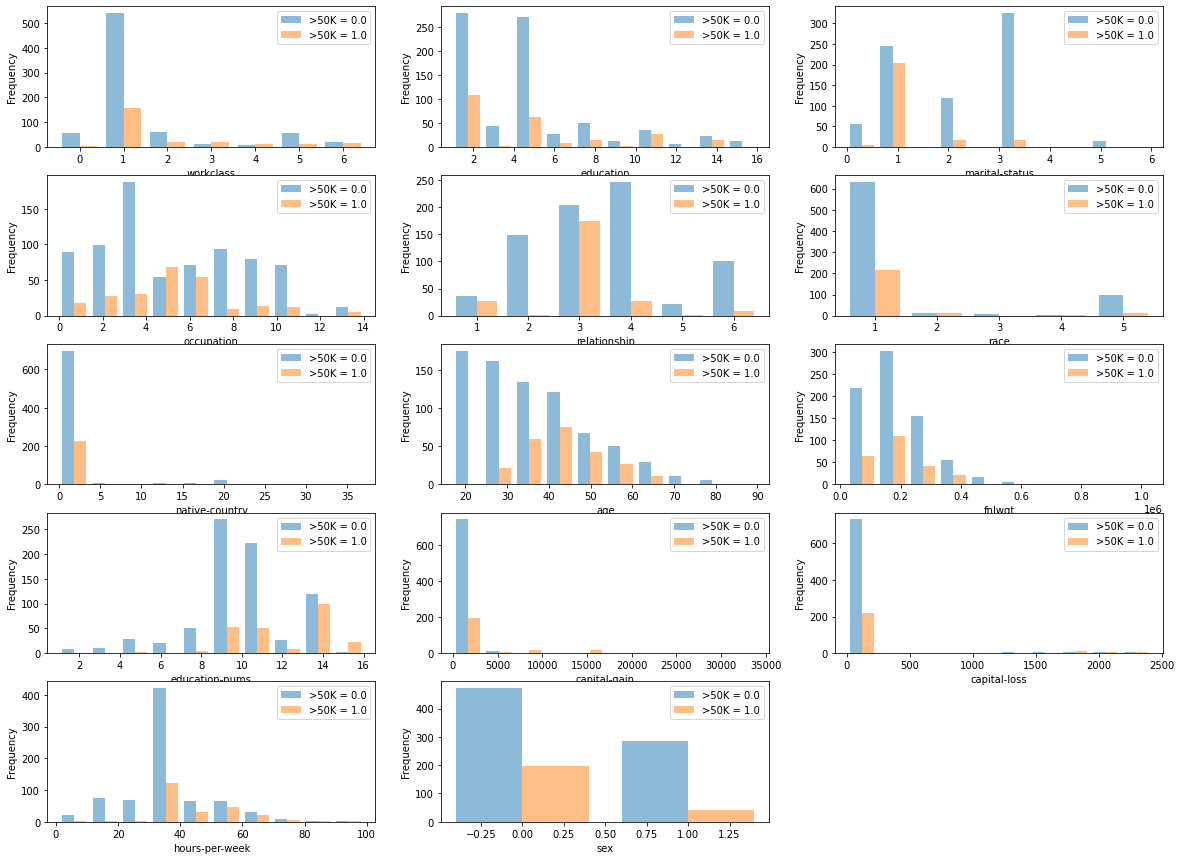

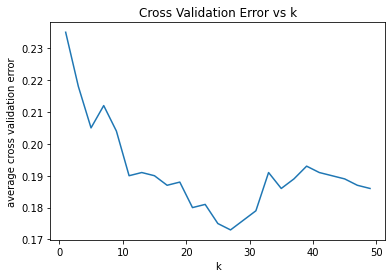

Investigating depths...


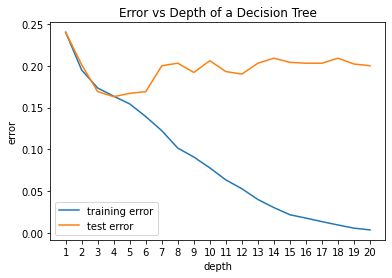

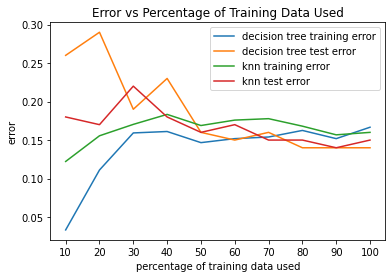

Done


In [ ]:

######################################################################
# main
######################################################################

def main():
    
    
    
    # load adult_subsample dataset with correct file path
    ### ========== TODO : START ========== ###
    data_file =  "/content/drive/My Drive/CS M146/adult_subsample.csv"
    ### ========== TODO : END ========== ###
    



    data = load_data(data_file, header=1, predict_col=-1)

    X = data.X; Xnames = data.Xnames
    y = data.y; yname = data.yname
    n,d = X.shape  # n = number of examples, d =  number of features

    

    plt.figure()
    #========================================
    # part a: plot histograms of each feature
    print('Plotting...')
    plot_histograms (X, y, Xnames=Xnames, yname=yname)
    




    ### ========== TODO : START ========== ###
    # part i: Preprocess X (e.g., normalize)
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    ### ========== TODO : END ========== ###




    #========================================
    # train Majority Vote classifier on data
    print('Classifying using Majority Vote...')
    clf = MajorityVoteClassifier() # create MajorityVote classifier, which includes all model parameters
    clf.fit(X, y)                  # fit training data using the classifier
    y_pred = clf.predict(X)        # take the classifier and run it on the training data
    train_error = 1 - metrics.accuracy_score(y, y_pred, normalize=True)
    print('\t-- training error: %.3f' % train_error)





    ### ========== TODO : START ========== ###
    # part b: evaluate training error of Random classifier
    print('Classifying using Random...')
    clf = RandomClassifier()  # create Random classifier, which includes all model parameters
    clf.fit(X, y)             # fit training data using the classifier
    y_pred = clf.predict(X)   # take the classifier and run it on the training data
    train_error = 1 - metrics.accuracy_score(y, y_pred, normalize=True)
    print('\t-- training error: %.3f' % train_error)

    ### ========== TODO : END ========== ###





    ### ========== TODO : START ========== ###
    # part c: evaluate training error of Decision Tree classifier
    print('Classifying using Decision Tree...')
    clf = DecisionTreeClassifier(criterion="entropy")
    clf.fit(X, y)
    y_pred = clf.predict(X)
    train_error = 1 - metrics.accuracy_score(y, y_pred, normalize=True)
    print('\t-- training error: %.3f' % train_error)

    ### ========== TODO : END ========== ###






    ### ========== TODO : START ========== ###
    # part d: evaluate training error of k-Nearest Neighbors classifier
    # use k = 3, 5, 7 for n_neighbors
    print('Classifying using k-Nearest Neighbors...')
    clf = KNeighborsClassifier(n_neighbors=7)
    clf.fit(X, y)
    y_pred = clf.predict(X)
    train_error = 1 - metrics.accuracy_score(y, y_pred, normalize=True)
    print('\t-- training error: %.3f' % train_error)
    ### ========== TODO : END ========== ###





    ### ========== TODO : START ========== ###
    # part e: use cross-validation to compute average training and test error of classifiers
    print('Investigating various classifiers...')
    classifiers = {"Majority Vote Classifier": MajorityVoteClassifier(),
                   "Random Classifier": RandomClassifier(),
                   "Decision Tree Classifier": DecisionTreeClassifier(criterion="entropy"),
                   "5-Neighbors Classifier": KNeighborsClassifier(n_neighbors=5)}
    for classifier in classifiers:
      train_error, test_error, f1_score = error(classifiers[classifier], X, y, 100)
      print('\t-- ' + classifier)
      print('\t\t-- training error: %.3f' % train_error)
      print('\t\t-- test error: %.3f' % test_error)
      print('\t\t-- f1 score: %.3f' % f1_score)
    ### ========== TODO : END ========== ###





    ### ========== TODO : START ========== ###
    # part f: use 10-fold cross-validation to find the best value of k for k-Nearest Neighbors classifier
    print('Finding the best k...')
    k_to_score = {}
    for k in range(1, 50, 2):
      train_error, test_error, f1_score = error(KNeighborsClassifier(n_neighbors=k), X, y, 10)
      scores = cross_val_score(KNeighborsClassifier(n_neighbors=k), X, y, cv=10)
      k_to_score[k] = 1.0 * sum(scores) / 10
    plt.figure()
    plt.plot(list(k_to_score.keys()), [1-i for i in list(k_to_score.values())])
    plt.xlabel("k")
    plt.ylabel("average cross validation error")
    plt.title('Cross Validation Error vs k')
    plt.show()

    ### ========== TODO : END ========== ###





    ### ========== TODO : START ========== ###
    # part g: investigate decision tree classifier with various depths
    print('Investigating depths...')
    depth_to_scores = {}
    for depth in range(1, 21):
      train_error, test_error, f1_score = error(DecisionTreeClassifier(criterion="entropy", max_depth=depth), X, y, test_size=0.1)
      depth_to_scores[depth] = (train_error, test_error)
    plt.figure()
    plt.plot(list(depth_to_scores.keys()), [scores[0] for scores in depth_to_scores.values()], label="training error")
    plt.plot(list(depth_to_scores.keys()), [scores[1] for scores in depth_to_scores.values()], label="test error")
    plt.xlabel("depth")
    plt.ylabel("error")
    plt.title('Error vs Depth of a Decision Tree')
    plt.xticks(ticks=range(1, 21))
    plt.legend()
    plt.show()

    ### ========== TODO : END ========== ###





    ### ========== TODO : START ========== ###
    # part h: investigate decision tree and k-Nearest Neighbors classifier with various training set sizes
    def helper(clf, X_train, y_train, X_test, y_test):
      clf.fit(X_train, y_train)
      y_pred = clf.predict(X_train)
      train_error = 1 - metrics.accuracy_score(y_train, y_pred, normalize=True)
      y_pred = clf.predict(X_test)
      test_error = 1 - metrics.accuracy_score(y_test, y_pred, normalize=True)
      return (train_error, test_error)
    
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=0)
    train_index, test_index = list(sss.split(X, y))[0]
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    dt_errors = []
    knn_errors = []
    for perc in range(10, 100, 10):
      sss = StratifiedShuffleSplit(n_splits=1, train_size=1.0 * perc / 100, random_state=0)
      train_subportion_index = list(sss.split(X_train, y_train))[0][0]
      X_train_subportion = X_train[train_subportion_index]
      y_train_subportion = y_train[train_subportion_index]
      
      dt_errors.append(helper(DecisionTreeClassifier(criterion="entropy", max_depth=4), X_train_subportion, y_train_subportion, X_test, y_test))
      knn_errors.append(helper(KNeighborsClassifier(n_neighbors=15), X_train_subportion, y_train_subportion, X_test, y_test))
      
    dt_errors.append(helper(DecisionTreeClassifier(criterion="entropy", max_depth=4), X_train, y_train, X_test, y_test))
    knn_errors.append(helper(KNeighborsClassifier(n_neighbors=15), X_train, y_train, X_test, y_test))

    plt.figure()
    plt.plot(range(10, 110, 10), [dt_error[0] for dt_error in dt_errors], label="decision tree training error")
    plt.plot(range(10, 110, 10), [dt_error[1] for dt_error in dt_errors], label="decision tree test error")
    plt.plot(range(10, 110, 10), [knn_error[0] for knn_error in knn_errors], label="knn training error")
    plt.plot(range(10, 110, 10), [knn_error[1] for knn_error in knn_errors], label="knn test error")
    plt.xlabel("percentage of training data used")
    plt.ylabel("error")
    plt.title('Error vs Percentage of Training Data Used')
    plt.xticks(ticks=range(10, 110, 10))
    plt.legend()
    plt.show()
 
    ### ========== TODO : END ========== ###
 
    print('Done')


if __name__ == "__main__":
    main()
